# Classifying data with Neural Networks

In this notebook we will see how we can classify data with a neural network. We will use the famous IRIS dataset and train our network to predict the species of an iris flower based on four features of that flower.

## The IRIS dataset

The IRIS dataset is a well-known and frequently used dataset in the field of machine learning and statistics. It is often used as a benchmark for classification tasks. The dataset is named after the iris flower, as it contains measurements of various attributes of three different species of iris flowers.

The IRIS dataset consists of ***150 samples***, with each sample representing an individual iris flower. Each flower sample is described by ***four features*** or attributes:

1. **Sepal length**: It represents the length of the sepal, which is the outermost whorl of the flower. It is measured in centimeters.
2. **Sepal width**: It denotes the width of the sepal, measured in centimeters.
3. **Petal length**: It represents the length of the petal, which is the innermost whorl of the flower. It is measured in centimeters.
4. **Petal width**: It denotes the width of the petal, measured in centimeters.

Based on these four features, the IRIS dataset aims to classify each iris flower into one of ***three species***:

1. **Setosa**: Iris setosa is one of the species of iris flowers. It is known for its distinctive appearance, with relatively small sepal and petal sizes.
2. **Versicolor**: Iris versicolor is another species in the iris family. It has intermediate sepal and petal sizes compared to the other two species.
3. **Virginica**: Iris virginica is the third species in the dataset. It typically has the largest sepal and petal sizes among the three species.

The IRIS dataset is widely used for tasks such as classification, clustering, and data visualization. Its simplicity, small size, and well-defined class labels make it an ideal starting point for exploring and evaluating various machine learning algorithms and techniques.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# First we will load the iris dataset. This dataset contains measurements of different flower types
# like the sepal length, the sepal width, petal length length and petal width
iris = load_iris(as_frame=True)
X = iris['data']
y = iris['target']

In [3]:
# Let's have a look at the four features of the dataset
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [4]:
# And now let's have a look at the labels
y.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int32

In [5]:
# Let's have a look at how many samples of each species are in the dataset
np.unique(y, return_counts=True)

(array([0, 1, 2]), array([50, 50, 50], dtype=int64))

So there are 50 samples of each species in the dataset. The species are encoded by the numbers 0, 1 and 2. Now lets build a dataset class for the IRIS dataset.

## Feature Engineering
For training neural networks as well as for other machine learning algorithms it is important to standardize the features of our dataset. That means shrinking the values to a range between 0 and 1 (MinMaxScaler) or mapping the features to a standard normal distribution (StandardScaler).

The library SciKit Learn offers you a lot of scaling techniques already implemented in the `sklearn.preprossesing` package. You can have a look at them here: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing

**StandardScaler**: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler
**MinMaxScaler**: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler

Your task is to apply standard scaling to all four features of the IRIS dataset.

In [6]:
# Let's create an instance of StandardScaler
scaler = StandardScaler()
# Apply standard scaling to our features
X_scaled = scaler.fit_transform(X)

In [7]:
# Now let's again have a look at our dataset after it has been scaled
pd.DataFrame(X_scaled).head()

,0,1,2,3
0,-0.900681,1.019004,-1.340227,-1.315444
1,-1.143017,-0.131979,-1.340227,-1.315444
2,-1.385353,0.328414,-1.397064,-1.315444
3,-1.506521,0.098217,-1.283389,-1.315444
4,-1.021849,1.249201,-1.340227,-1.315444


Text(0.5, 1.0, 'After scaling')

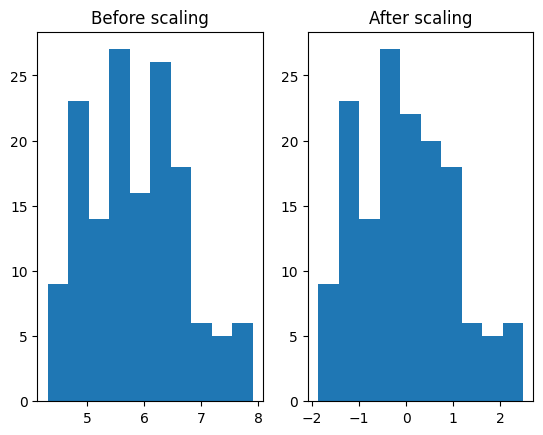

In [8]:
fig, ax = plt.subplots(1, 2)
ax[0].hist(X.iloc[:, 0])
ax[0].set_title("Before scaling")
ax[1].hist(X_scaled[:, 0])
ax[1].set_title("After scaling")

The features have been standardizes, that means they have been shifted by the value of their mean to the left and then divided by their own standard deviation. We can see this effect by comparing the mean and the variance of a feature before and after applying the standard scaler.

In [9]:
print("Mean before scaling:", X.iloc[:, 0].mean(), ", Variance before scaling: ", X.iloc[:, 0].var())
print("Mean after scaling:", X_scaled[:, 0].mean(), ", Variance after scaling: ", X_scaled[:, 0].var())

Mean before scaling: 5.843333333333334 , Variance before scaling:  0.6856935123042507
Mean after scaling: -4.736951571734001e-16 , Variance after scaling:  1.0


## Building a dataset class and a data loader

Now that we know how to load and prpepare the IRIS dataset for training it is time to build a dataset class.

In [10]:
class IRISDataset(Dataset):
    """
    This class loads the IRIS data
    """
    def __init__(self, is_train_dataset=True):
        """
        Initialize the dataset class
        :param is_train_dataset: True if this class should use the training data, False otherwise
        """
        # Load the IRIS dataset
        iris = load_iris(as_frame=False)
        
        # Extract features and labels from the dataset
        X = iris['data']
        y = iris['target']
        
        # Apply standard scaling to the features. This makes model training more stable.
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Split the data set into training and testing
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=2)
        
        # Check whether the training or test data should be loaded
        if is_train_dataset:
            self.data = X_train
            self.labels = y_train
        else:
            self.data = X_test
            self.labels = y_test

    def __len__(self):
        """
        This function returns the total number of items in the dataset.
        We are using a numpy array in this dataset which has an attribut named shape.
        The first dimension of shape is equal to the number of items in the dataset.
        :return: The number of rows in the CSV file
        """
        return self.data.shape[0]

    def __getitem__(self, idx):
        """
        This function returns a single tuple from the dataset.
        :param idx: The index of the tuple that should be returned.
        :return: Tuple of a feature vector and a y-value
        """
        return self.data[idx], self.labels[idx]

In [11]:
# We create two datasets: one for training and another one for testing
dataset_train = IRISDataset(is_train_dataset=True)
dataset_test = IRISDataset(is_train_dataset=False)

In [12]:
# Let's check how many items are in the training and the test dataset
print("Train dataset size:", len(dataset_train), ", Test dataset size", len(dataset_test))

Train dataset size: 120 , Test dataset size 30


In [13]:
# Let's sample the first item of the training dataset.
# You will get a tuple consisting of the feature vector and the label of the item.
dataset_train[0]

(array([ 0.4321654 , -0.59237301,  0.59224599,  0.79067065]), 2)

In PyTorch you also have to define a data loader for each dataset which is responsible for drawing random samples from the dataset. The **batch size** defines how many random samples should be drawn from the dataset. As we have a training and a test dataset we also need to create one data loader for each of the datasets.

In [14]:
# TODO Create data loaders for the IRIS dataset
dataloader_train = DataLoader(dataset_train, batch_size=16, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=30, shuffle=True)

In [15]:
# We can get a random sample from a data loader by wrapping it into next(iter()).
# You will get a tuple that contains a batch of feature vectors and their corresponding labels.
# If you run this code multiple times you always will get another random sample.
next(iter(dataloader_test))

[tensor([[ 0.6745, -0.5924,  1.0469,  1.1856],
         [ 0.3110, -0.1320,  0.6491,  0.7907],
         [-1.2642,  0.7888, -1.0560, -1.3154],
         [-1.0218,  0.3284, -1.4539, -1.3154],
         [-0.4160, -1.2830,  0.1375,  0.1325],
         [ 1.0380, -1.2830,  1.1606,  0.7907],
         [-0.9007,  1.7096, -1.0560, -1.0522],
         [ 1.6438,  0.3284,  1.2743,  0.7907],
         [-1.6277, -1.7434, -1.3971, -1.1838],
         [ 1.0380,  0.5586,  1.1038,  1.7121],
         [-0.5372,  1.9398, -1.1697, -1.0522],
         [ 0.6745,  0.3284,  0.8764,  1.4488],
         [-1.2642, -0.1320, -1.3402, -1.4471],
         [-1.5065,  0.0982, -1.2834, -1.3154],
         [ 0.7957, -0.5924,  0.4786,  0.3958],
         [-0.2948, -0.8226,  0.2512,  0.1325],
         [-1.3854,  0.3284, -1.2266, -1.3154],
         [-0.1737, -0.3622,  0.2512,  0.1325],
         [ 0.6745, -0.3622,  0.3081,  0.1325],
         [ 1.0380, -0.1320,  0.7059,  0.6590],
         [-1.7489,  0.3284, -1.3971, -1.3154],
         [ 1.

## Building a neural network for classification

Great! We now know how to load the IRIS dataset, preprocess it, split it into training and test data and build Dataset and DataLoader classes. The next step is to define a neural network that is able to consume our data and predict the species based on the four features of the data.

In [16]:
class IRISClassificationNetwork(nn.Module):
    def __init__(self):
        """
        Here we define the layers of our neural network.
        """
        super(IRISClassificationNetwork, self).__init__()
        # Our data has four features, so the first linear layer has to have four input dimensions.
        self.layer1 = nn.Linear(4, 50)
        # The first hidden layer need to have the same input dimension as layer1 has outputs. 
        self.layer2 = nn.Linear(50, 50)
        # We have three different classes in out data, so the last linear layer must have 3 output dimensions.
        self.layer3 = nn.Linear(50, 3)
        self.activation = nn.ReLU()
        # The outputs of the last linear layer need to be mapped to a probability function.
        # This can be done by running the vectors through a softmax function.
        self.classification = nn.Softmax(dim=1)
        
    def forward(self, x):
        """
        The forward function takes a data vector and runs it through the layers of our neural network.
        :return: The forward function returns a vector of size 3 which contains the
            probabilities for all three classes for a given data vector.
        """
        # Run the input through the first linear layer and then through the activation function.
        x = self.activation(self.layer1(x))
        # Run the outputs of layer 1 through layer 2.
        x = self.activation(self.layer2(x))
        # Run the outputs of layer 2 through the third linear layer and then through the softmax classification function.
        x = self.classification(self.layer3(x))
        return x

In [17]:
# Now that we have defined the network class we need to create an instance of it
net = IRISClassificationNetwork()

In [18]:
def get_accuracy(net, dataloader):
    """
    This function computes the accuracy of the neural network by sampling data from a
    data loader, running it through the network and computing the percentage of correct predictions.
    :param net: The neural network
    :param dataloader: A DataLoader instance
    """
    # torch.no_grad means that no gradients should be computed when running data through the network.
    # When we run test data through the network this should not have an effect on our training, that is
    # why we don't want to compute gradients here.
    with torch.no_grad():
        X_test, y_test = next(iter(dataloader))
        y_pred = net(X_test.to(torch.float32))
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.float32)
        return correct.mean().item()

In [19]:
# Let's check the accuracy before training the network
print("Accuracy before training:", get_accuracy(net, dataloader_test))

Accuracy before training: 0.36666667461395264


The accuracy of the untrained network is very bad, because the parameters of the network are initialized randomly. Let's train the network to find the parameters that allow us to make better predictions for the classes of our flowers.

## Training the network

In [20]:
# Here we define how long we want to train the network
num_epochs = 250
# This is our loss function. Which one do we need for classification: MSELoss or CrossEntropyLoss?
criterion = nn.CrossEntropyLoss()
# This is the algorithm used for optimizing our neural network parameters.
optimizer = optim.Adam(net.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Draw data from the data loader
    X, Y = next(iter(dataloader_train))
    
    # Forward pass
    outputs = net(X.to(torch.float32))
    
    # Compute the difference between the true labels and the predicted labels
    loss = criterion(outputs, Y.to(torch.long))

    # First reset the gradients
    optimizer.zero_grad()
    
    # Then compute the new gradients
    loss.backward()
    
    # And finally perform the backpropagation step
    optimizer.step()

    # Print some metrics about the learning progress
    if (epoch + 1) % 10 == 0:
        accuracy = get_accuracy(net, dataloader_test)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy on test data:", accuracy)

C:\Users\tilof\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\autograd\__init__.py:200: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ..\c10\cuda\CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [10/250], Loss: 1.0342, Accuracy on test data: 0.4000000059604645
Epoch [20/250], Loss: 1.0147, Accuracy on test data: 0.800000011920929
Epoch [30/250], Loss: 0.9456, Accuracy on test data: 0.7666666507720947
Epoch [40/250], Loss: 0.8926, Accuracy on test data: 0.800000011920929
Epoch [50/250], Loss: 0.8386, Accuracy on test data: 0.8333333134651184
Epoch [60/250], Loss: 0.8800, Accuracy on test data: 0.8666666746139526
Epoch [70/250], Loss: 0.7504, Accuracy on test data: 0.8666666746139526
Epoch [80/250], Loss: 0.7091, Accuracy on test data: 0.8333333134651184
Epoch [90/250], Loss: 0.6661, Accuracy on test data: 0.8666666746139526
Epoch [100/250], Loss: 0.7385, Accuracy on test data: 0.8666666746139526
Epoch [110/250], Loss: 0.6871, Accuracy on test data: 0.8999999761581421
Epoch [120/250], Loss: 0.7192, Accuracy on test data: 0.8999999761581421
Epoch [130/250], Loss: 0.6934, Accuracy on test data: 0.8999999761581421
Epoch [140/250], Loss: 0.6540, Accuracy on test data: 0.899999

In [21]:
# Let's check the accuracy after training the network
print("Accuracy after training:", get_accuracy(net, dataloader_test))

Accuracy after training: 0.9333333373069763


The accuracy has improved a lot. It has nearly reached 100% which is very good.

## Making predictions

Now that we have a trained network we can make predictions for data vectors.

In [22]:
# First let's sample a data vector from our test dataset.
X, y = dataset_test[0]
# Create torch tensors
X = torch.tensor(X).to(torch.float32)
y = torch.tensor(y)
print("This is our data vector:", X)
print("And this is the corresponding label:", y.item())

This is our data vector: tensor([-1.5065,  0.7888, -1.3402, -1.1838])
And this is the corresponding label: 0


In [23]:
# Run the data vector through the network
with torch.no_grad():
    y_pred = net(X.reshape(1, -1))
    
# Retransform the prediction to a numpy array
y_pred = y_pred.numpy()

print("This is the prediction of the neural network:", y_pred)

This is the prediction of the neural network: [[9.9939942e-01 5.9499586e-04 5.6224708e-06]]


<BarContainer object of 3 artists>

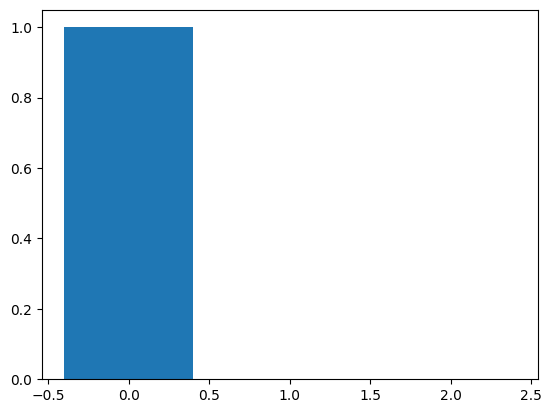

In [24]:
# Let's plot the predicted classes with a histogram
possible_classes = [0,1,2]
# We plot the possible classes on the x-axis and the probabilities on the y-axis
plt.bar(possible_classes, y_pred.squeeze())

As you can see the network predicts the label 0 with a probabiliity of nearly 100%. The other probabilities are so small that the can't even be seen in the bar chart.